In [1]:
import logging
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from pathlib import Path
from vangja.components import LinearTrend, FourierSeasonality
from vangja.data_utils import (
    download_data,
    process_data,
    generate_train_test_df_around_point,
)

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

Importing plotly failed. Interactive plots will not work.


# Fetch data

In [2]:
dfs = download_data(Path("./data"))
indexes = process_data(dfs[0])
smp = [index for index in indexes if index["series"].iloc[0] == "^GSPC"]
gspc_tickers = process_data(dfs[1])

# Generate models

In [6]:
# model_components = [
#     [LinearTrend(pool_cols="series", pool_type=pt) for pt in ["individual", "partial"]],
#     [
#         FourierSeasonality(
#             period=365.25, series_order=10, pool_cols="series", pool_type=pt
#         )
#         for pt in ["individual", "partial"]
#     ],
#     [
#         FourierSeasonality(
#             period=91.3125, series_order=n, pool_cols="series", pool_type=pt
#         )
#         for n in range(7, 10)
#         for pt in ["individual", "partial"]
#     ],
#     [
#         FourierSeasonality(
#             period=30.4375, series_order=n, pool_cols="series", pool_type=pt
#         )
#         for n in range(4, 7)
#         for pt in ["individual", "partial"]
#     ],
#     [
#         FourierSeasonality(period=7, series_order=3, pool_cols="series", pool_type=pt)
#         for pt in ["individual", "partial"]
#     ],
# ]

model_components = [
    [LinearTrend(allow_tune=False)],
    [
        FourierSeasonality(period=365.25, series_order=10, allow_tune=allow_tune)
        for allow_tune in [True]
    ],
    # [
    #     FourierSeasonality(period=91.3125, series_order=n, allow_tune=allow_tune)
    #     for n in range(7, 10)
    #     for allow_tune in [True, False]
    # ],
    # [
    #     FourierSeasonality(period=30.4375, series_order=n, allow_tune=allow_tune)
    #     for n in range(4, 7)
    #     for allow_tune in [True, False]
    # ],
    [
        FourierSeasonality(period=7, series_order=3, allow_tune=allow_tune)
        for allow_tune in [True, False]
    ],
]

# model_components = [
#     [LinearTrend(allow_tune=False, pool_cols="series", pool_type="individual")],
#     [
#         FourierSeasonality(
#             period=365.25,
#             series_order=10,
#             allow_tune=allow_tune,
#             pool_cols="series",
#             pool_type="individual",
#         )
#         for allow_tune in [True]
#     ],
#     # [
#     #     FourierSeasonality(
#     #         period=91.3125,
#     #         series_order=n,
#     #         allow_tune=allow_tune,
#     #         pool_cols="series",
#     #         pool_type="individual",
#     #     )
#     #     for n in range(7, 10)
#     #     for allow_tune in [True, False]
#     # ],
#     # [
#     #     FourierSeasonality(
#     #         period=30.4375,
#     #         series_order=n,
#     #         allow_tune=allow_tune,
#     #         pool_cols="series",
#     #         pool_type="individual",
#     #     )
#     #     for n in range(4, 7)
#     #     for allow_tune in [True, False]
#     # ],
#     [
#         FourierSeasonality(
#             period=7,
#             series_order=3,
#             allow_tune=allow_tune,
#             pool_cols="series",
#             pool_type="individual",
#         )
#         for allow_tune in [True, False]
#     ],
# ]

In [7]:
q = [(0, [mc]) for mc in model_components[0]]
models = []

while len(q):
    level, model = q.pop(0)
    if level + 1 == len(model_components):
        models.append(model)
        continue

    mcs = model_components[level + 1]
    for mc in mcs:
        # if mc.pool_type == "partial":
        #     q.append(
        #         (
        #             level + 1,
        #             model
        #             + [
        #                 Constant(
        #                     lower=-1, upper=1, pool_cols="series", pool_type="partial"
        #                 )
        #                 * mc
        #             ],
        #         )
        #     )

        q.append((level + 1, model + [mc]))
        q.append((level + 1, model))

In [8]:
def sum_models(models):
    s = None
    for model in models:
        if s is None:
            s = model
        else:
            s += model

    return s

In [9]:
models = (
    [
        LinearTrend() * (FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3)),
        LinearTrend() * FourierSeasonality(365.25, 10),
        LinearTrend() * FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10),
        LinearTrend() + FourierSeasonality(7, 3),
    ]
    + [
        model[0] * sum_models(model[1:]) if len(model) > 1 else model[0]
        for model in models
    ]
    + [sum_models(model) if len(model) > 1 else model[0] for model in models]
)

In [10]:
str_models = {""}
final_models = []
for model in models:
    str_model = str(model)
    if str_model in str_models:
        continue

    str_models.add(str_model)
    final_models.append(model)

len(final_models)

15

In [ ]:
str_models

{'',
 'LT(n=25,r=0.8,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete))',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=Fals

# Test prophet

In [14]:
def get_prophet_metrics(y_trues, y_preds, horizon):
    result = None
    for y_true, y_pred in zip(y_trues, y_preds):
        group_name = y_true["series"].iloc[0]
        single_metrics = {"mse": {}, "rmse": {}, "mae": {}, "mape": {}}
        single_metrics["mse"][group_name] = mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["rmse"][group_name] = root_mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mae"][group_name] = mean_absolute_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mape"][group_name] = mean_absolute_percentage_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        if result is None:
            result = pd.DataFrame(single_metrics)
        else:
            result = pd.concat((result, pd.DataFrame(single_metrics)))

    return result

In [15]:
point = "2014-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=True, point=point
)
train_df_ticker, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=91, horizon=365, dfs=gspc_tickers, for_prophet=True, point=point
)

In [16]:
context_prophet = Prophet(seasonality_mode="multiplicative")
context_prophet.fit(train_df_smp[0])
context_future = context_prophet.make_future_dataframe(
    periods=365, include_history=True
)
context_yhat = context_prophet.predict(context_future)
context_metrics = get_prophet_metrics(test_df_smp, [context_yhat], 365)
context_metrics

,mse,rmse,mae,mape
^GSPC,0.075807,0.275331,0.272638,0.259551


In [17]:
train_df_ticker[0]

,typical_price,ds,series,y
18901,104.404131,2013-10-02,PRGO,0.796233
18902,104.943030,2013-10-03,PRGO,0.800343
18903,106.336274,2013-10-04,PRGO,0.810968
18904,106.851518,2013-10-05,PRGO,0.814898
18905,107.366762,2013-10-06,PRGO,0.818827
...,...,...,...,...
18987,127.067767,2013-12-27,PRGO,0.969076
18988,127.290725,2013-12-28,PRGO,0.970776
18989,127.513683,2013-12-29,PRGO,0.972477
18990,127.736640,2013-12-30,PRGO,0.974177


In [20]:
prophet_forecasts = []

for df, df_test in tqdm(zip(train_df_ticker, test_df_tickers)):
    # if df["series"].iloc[0] not in good_stocks:
    #     continue
    
    prophet = Prophet(
        seasonality_mode="multiplicative",
        n_changepoints=25,
        yearly_seasonality=True,
        weekly_seasonality=True,
    )
    # prophet.add_regressor("smp_weekly", standardize=False, mode="additive")
    # prophet.add_regressor("smp_yearly", standardize=False, mode="additive")
    # prophet.add_regressor("smp_yhat", standardize=False, mode="additive")

    train_df = df.copy()
    # train_df["smp_weekly"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["weekly"].to_numpy()
    # train_df["smp_yhat"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["yhat"].to_numpy()
    # train_df["smp_yearly"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["yearly"].to_numpy()

    prophet.fit(train_df)

    future = prophet.make_future_dataframe(periods=365, include_history=True)
    # future["smp_weekly"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["weekly"].to_numpy()
    # future["smp_yhat"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["yhat"].to_numpy()
    # future["smp_yearly"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["yearly"].to_numpy()

    prophet_forecasts.append(prophet.predict(future))

prophet_metrics = get_prophet_metrics(test_df_tickers, prophet_forecasts, 365)
prophet_metrics.to_csv("prophet_results_2014.csv")
prophet_metrics["mape"].mean()

437it [35:23,  4.86s/it]


26.3301940204345

/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing py

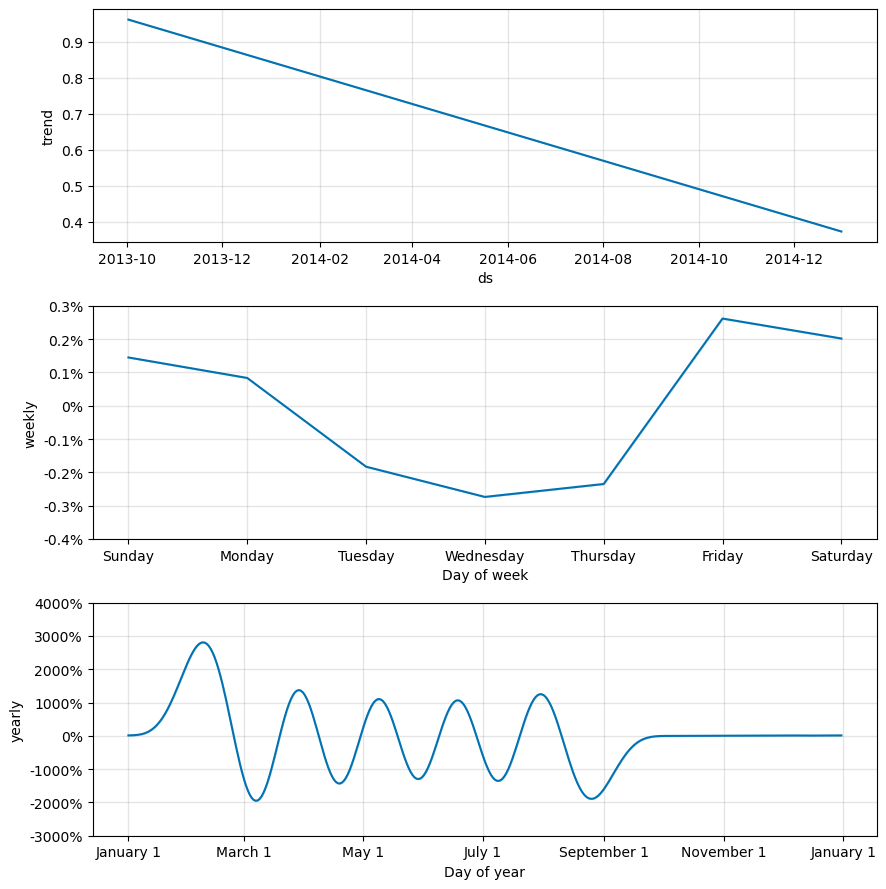

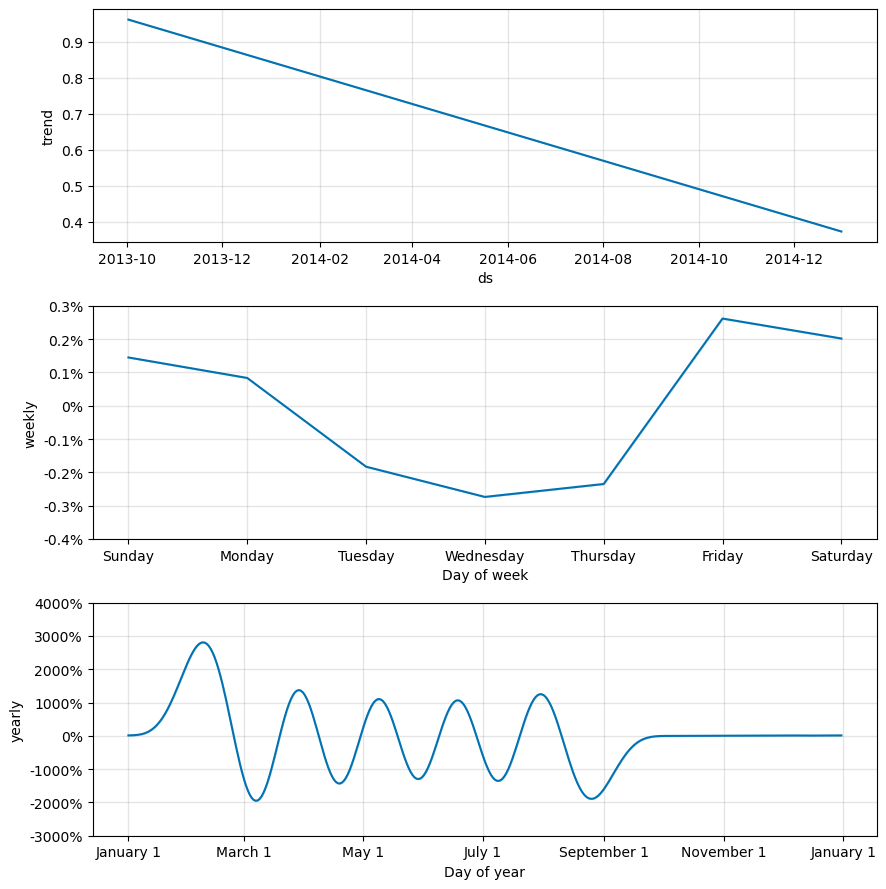

In [31]:
prophet.plot_components(prophet_forecasts[-1])

In [11]:
prophet_metrics

,mse,rmse,mae,mape
MNST,0.033756,0.183728,0.109248,0.074187
PCAR,0.138471,0.372117,0.335363,0.267789
MAR,0.177548,0.421364,0.344359,0.408106
PEP,0.010829,0.104062,0.079326,0.070397
ANSS,0.745597,0.863479,0.735714,0.572273
...,...,...,...,...
DHR,0.002577,0.050760,0.040594,0.038513
RTX,0.196260,0.443012,0.388458,0.346498
FTI,0.558551,0.747363,0.606683,0.389519
EMR,0.086647,0.294358,0.267315,0.237310


# Test model

In [14]:
def run_test(idx, point):
    train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
        window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
    )
    model = final_models[idx]
    model.fit(train_df_smp, progressbar=False)
    map_approx = model.map_approx
    model_metrics = []

    for smp_ticker in tqdm(smp + smp_tickers):
        check = generate_train_test_df_around_point(
            window=365 * 1,
            horizon=365,
            dfs=[smp_ticker],
            for_prophet=False,
            point=point,
        )
        if check is None:
            continue

        train_df_tickers, test_df_tickers, scales_tickers = check
        model.map_approx = map_approx
        model.tune(train_df_tickers, progressbar=False)
        yhat = model.predict(365)
        yhat.to_csv(f"./out/model_{idx}_series_{smp_ticker['series'].iloc[0]}.csv")
        model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

    print(f"{idx} - {model}: {pd.concat(model_metrics)['mape'].mean()}")
    return pd.concat(model_metrics)

In [96]:
# from joblib import Parallel, delayed

"""
100%|██████████| 127/127 [09:50<00:00,  4.65s/it]
0 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete)): 0.15938053967032853
100%|██████████| 127/127 [05:26<00:00,  2.57s/it]
1 - LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete): 0.15760077719458276
100%|██████████| 127/127 [06:05<00:00,  2.88s/it]
2 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete)): 0.1613983544054207
100%|██████████| 127/127 [05:36<00:00,  2.65s/it]
3 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete): 0.2135529074152472
100%|██████████| 127/127 [03:38<00:00,  1.72s/it]
4 - LT(n=25,r=0.8,at=False,complete): 0.2123689870169386
100%|██████████| 127/127 [03:48<00:00,  1.80s/it]
5 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete): 0.21387403836166552
"""

point = "2006-01-01"
all_metrics = []
# all_metrics = Parallel(n_jobs=8, prefer="threads")(
#     delayed(run_test)(idx, point) for idx, model in enumerate(final_models[:5])
# )

# with open("./out/models.txt", "w") as f:
#     for idx, model in enumerate(final_models):
#         f.write(f"model_{idx}: {model}\n")

for idx, model in enumerate(final_models):
    all_metrics.append(run_test(idx, point))

100%|██████████| 504/504 [34:48<00:00,  4.14s/it]


0 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete)): 0.15084780966568953


100%|██████████| 504/504 [26:51<00:00,  3.20s/it]


1 - LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=False,complete): 0.15101299880893668


100%|██████████| 504/504 [14:31<00:00,  1.73s/it]


2 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete): 0.23179868015950725


100%|██████████| 504/504 [21:38<00:00,  2.58s/it]


3 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete): 0.14906985388701274


100%|██████████| 504/504 [19:49<00:00,  2.36s/it]


4 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete): 0.14915277599146487


100%|██████████| 504/504 [14:01<00:00,  1.67s/it]


5 - LT(n=25,r=0.8,at=False,complete) + FS(p=7,n=3,at=False,complete): 0.23083132671920667


100%|██████████| 504/504 [21:44<00:00,  2.59s/it]


6 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete)): 0.14998936264585022


100%|██████████| 504/504 [17:39<00:00,  2.10s/it]


7 - LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete): 0.1491083305827519


100%|██████████| 504/504 [20:04<00:00,  2.39s/it]


8 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete)): 0.15158811222516175


100%|██████████| 504/504 [17:11<00:00,  2.05s/it]


9 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete): 0.2328139526374169


100%|██████████| 504/504 [18:32<00:00,  2.21s/it]


10 - LT(n=25,r=0.8,at=False,complete): 0.23130798615609033


100%|██████████| 504/504 [20:50<00:00,  2.48s/it]


11 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete): 0.1466321610760913


100%|██████████| 504/504 [16:55<00:00,  2.02s/it]


12 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete): 0.1471390167141869


100%|██████████| 504/504 [19:30<00:00,  2.32s/it]


13 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete): 0.14837076729903897


100%|██████████| 504/504 [16:54<00:00,  2.01s/it]

14 - LT(n=25,r=0.8,at=False,complete) + FS(p=7,n=3,at=True,complete): 0.23237458534332991


In [107]:
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
)

model_metrics = []
tested_models = []

for smp_ticker in tqdm(smp + smp_tickers):
    check = generate_train_test_df_around_point(
        window=365 * 1, horizon=365, dfs=[smp_ticker], for_prophet=False, point=point
    )
    if check is None:
        continue

    train_df_tickers, test_df_tickers, scales_tickers = check
    ticker = train_df_tickers["series"].iloc[0]
    if ticker not in model_idxs:
        continue
    
    model_idx = model_idxs[ticker]
    model = final_models[model_idx]
    if model_idx not in tested_models:
        model.fit(train_df_smp, progressbar=False)
        tested_models.append(model_idx)

    map_approx = model.map_approx    
    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))
    model.map_approx = map_approx

print(f"{pd.concat(model_metrics)['mape'].mean()}")

  0%|          | 0/504 [00:00<?, ?it/s]

100%|██████████| 504/504 [35:32<00:00,  4.23s/it] 

0.1726415857563341


In [14]:
model = LinearTrend() * (
    FourierSeasonality(365.25, 10, allow_tune=True)
    + FourierSeasonality(7, 3, allow_tune=True)
)
model_metrics = []
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
)
model.fit(train_df_smp, progressbar=True)

for smp_ticker in tqdm(smp + smp_tickers):
    check = generate_train_test_df_around_point(
        window=365 * 1,
        horizon=365,
        dfs=[smp_ticker],
        for_prophet=False,
        point=point,
    )
    if check is None:
        continue

    train_df_tickers, test_df_tickers, scales_tickers = check
    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

print(f"{model}: {pd.concat(model_metrics)['mape'].mean()}")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f81fc97d1c0>>
Traceback (most recent call last):
  File "/home/jovan/miniconda3/envs/new_pymc_env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Output()

  0%|          | 1/504 [00:12<1:42:11, 12.19s/it]


KeyboardInterrupt: 

In [ ]:
model = LinearTrend(n_changepoints=25, changepoint_range=1, allow_tune=False) * (
    # FourierSeasonality(365.25 * 10, 30, allow_tune=True)
    # + FourierSeasonality(365.25 * 5, 20, allow_tune=True)
    FourierSeasonality(365.25, 10, allow_tune=True)
    + FourierSeasonality(91.3125, 7, allow_tune=True)
    + FourierSeasonality(30.4375, 5, allow_tune=True)
    + FourierSeasonality(7, 3, allow_tune=False)
)
point = "2014-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 80, horizon=365, dfs=smp, for_prophet=False, point=point
)

model.fit(train_df_smp, mcmc_samples=1000, nuts_sampler="numpyro")
yhat = model.predict(365)
print(model.metrics(test_df_smp, yhat, pool_cols="series")["mape"].iloc[0])
model.plot(yhat, test_df_smp, pool_cols="series")
model.fit_params["trace"].to_netcdf(Path("./") / "models" / "trace_80_y_q_m_w.nc")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [27]:
# model = LinearTrend(n_changepoints=25, changepoint_range=0.8, allow_tune=True) * (
#     FourierSeasonality(365.25, 10, allow_tune=True)
#     # + FourierSeasonality(91.3125, 7, allow_tune=True)
#     # + FourierSeasonality(30.4375, 5, allow_tune=True)
#     + FourierSeasonality(7, 3, allow_tune=False)
# )
model.load_trace(Path("./") / "models" / "trace.nc")
model.fit_params["map_approx"] = None
model.fit_params

{'map_approx': None,
 'trace': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data}

In [30]:
model_metrics = []
point = "2014-01-01"
model.right.left.tune_method = "same"

for gspc_ticker in tqdm(gspc_tickers):
    # if gspc_ticker["series"].iloc[0] not in good_stocks:
    #     continue
    
    check = generate_train_test_df_around_point(
        window=91,
        horizon=365,
        dfs=[gspc_ticker],
        for_prophet=False,
        point=point,
    )

    if check is None:
        continue
    
    # model.right.left.beta_sd = 0.001
    train_df_tickers, test_df_tickers, scales_tickers = check
    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

final_metrics = pd.concat(model_metrics)
final_metrics.to_csv("my_result_same_2014.csv")
print(f"{model}: {final_metrics['mape'].mean()}")

100%|██████████| 503/503 [1:36:39<00:00, 11.53s/it]

LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete)): 0.2796042158421335


In [13]:
final_metrics

,mse,rmse,mae,mape
MNST,0.152626,0.390674,0.303382,0.243985
PCAR,0.275405,0.524791,0.474087,0.379920
MAR,0.094609,0.307586,0.236133,0.284420
PEP,0.062247,0.249493,0.213506,0.192967
ANSS,0.866825,0.931034,0.797910,0.622437
...,...,...,...,...
DHR,0.030188,0.173746,0.140142,0.130662
RTX,0.257585,0.507528,0.446986,0.398962
FTI,0.410944,0.641049,0.519002,0.332890
EMR,0.008531,0.092363,0.081413,0.073916


In [18]:
prophet_metrics[prophet_metrics["mape"] > final_metrics["mape"]]["mape"].mean()

0.3332924989250238

In [19]:
final_metrics[prophet_metrics["mape"] > final_metrics["mape"]]["mape"].mean()

0.23714420578119663

In [22]:
good_stocks = prophet_metrics[prophet_metrics["mape"] > final_metrics["mape"]].index
good_stocks

Index(['MAR', 'WST', 'GE', 'HPQ', 'SPGI', 'BAX', 'NKE', 'ABT', 'INCY', 'VMC',
       ...
       'JCI', 'KMX', 'ZBH', 'VTR', 'MDLZ', 'NTAP', 'POOL', 'FTI', 'EMR',
       'SBUX'],
      dtype='object', length=138)

In [22]:
model.fit_params["trace"].to_netcdf(Path("./") / "models" / "trace.nc")

PosixPath('models/trace.nc')

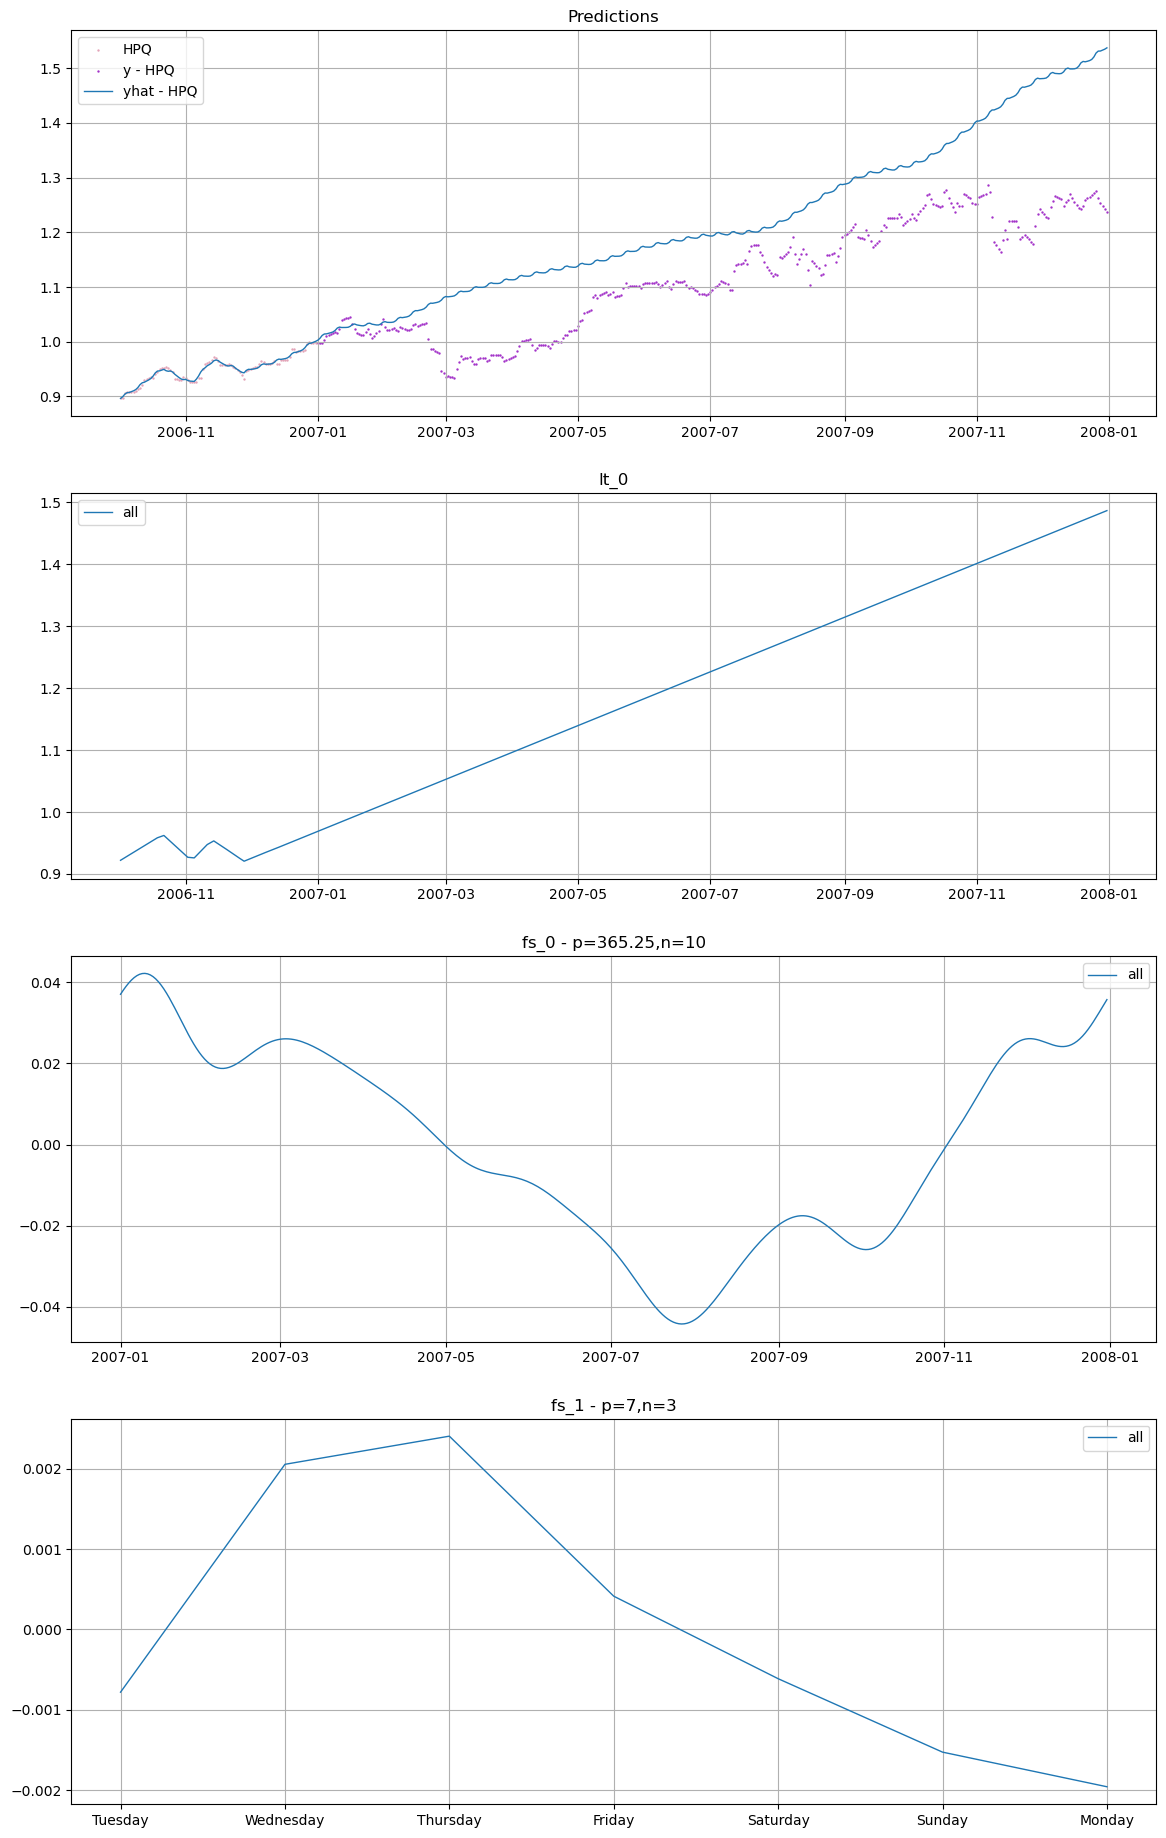

In [7]:
model.plot(yhat, test_df_tickers, pool_cols="series")

0.226718387077751


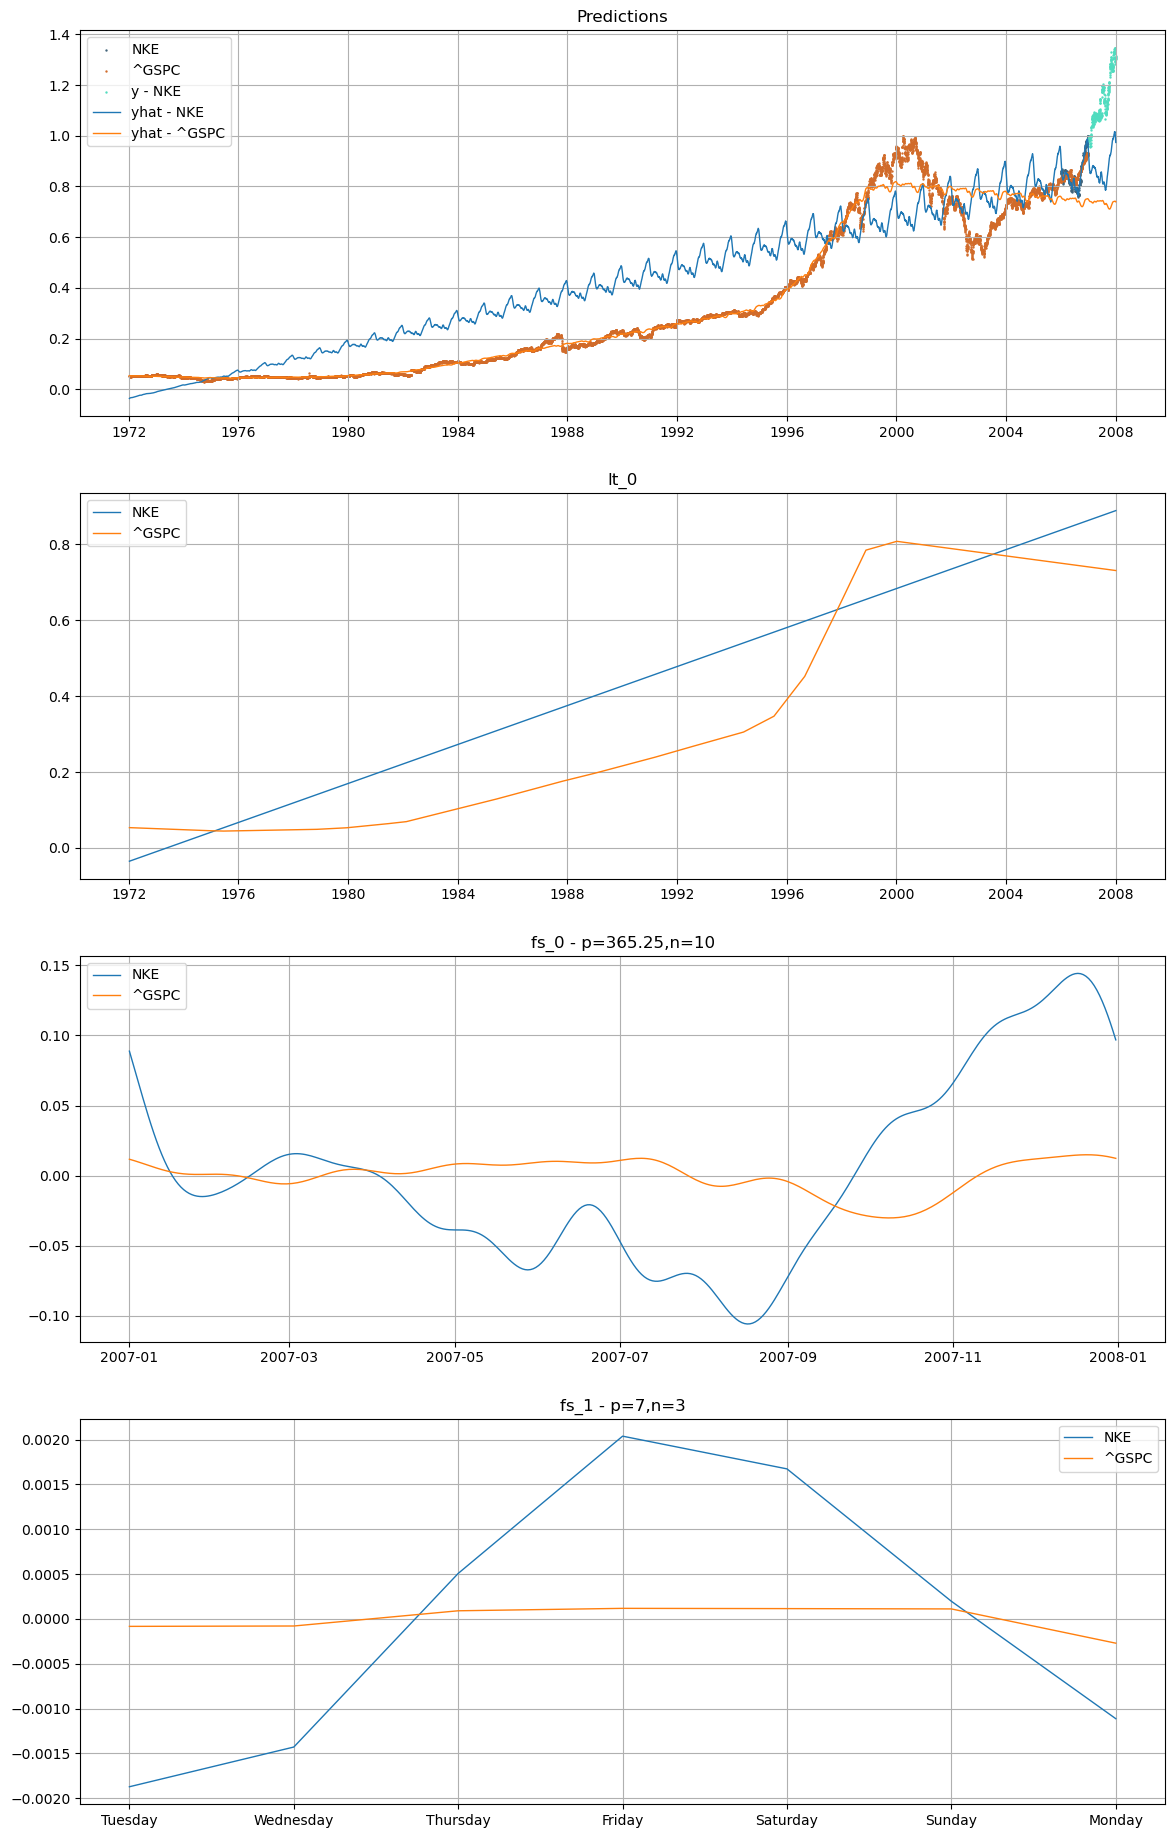

In [21]:
model = LinearTrend(pool_cols="series", pool_type="individual") * (
    FourierSeasonality(
        365.25, 10, allow_tune=False, pool_cols="series", pool_type="partial"
    )
    + FourierSeasonality(
        7, 3, allow_tune=False, pool_cols="series", pool_type="partial"
    )
)
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
)
train_df_tickers, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=365,
    horizon=365,
    dfs=[smp_tickers[-1]],
    for_prophet=False,
    point=point,
)

model.fit(pd.concat([train_df_smp, train_df_tickers]), progressbar=True)
yhat = model.predict(365)
print(
    model.metrics(pd.concat([test_df_smp, test_df_tickers]), yhat, pool_cols="series")[
        "mape"
    ].iloc[0]
)
model.plot(yhat, test_df_tickers, pool_cols="series")

In [70]:
def run_test_2(idx, point):
    train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
        window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
    )
    model = final_models[idx]
    model.fit(train_df_smp, progressbar=False)
    map_approx = model.map_approx
    model_metrics = []

    check = generate_train_test_df_around_point(
        window=365 * 1,
        horizon=365,
        dfs=smp + smp_tickers[::4],
        for_prophet=False,
        point=point,
    )

    train_df_tickers, test_df_tickers, scales_tickers = check
    model.map_approx = map_approx
    model.tune(train_df_tickers, progressbar=True)
    yhat = model.predict(365)
    yhat.to_csv(f"./out/single_model_{idx}.csv")
    model_metrics = model.metrics(test_df_tickers, yhat, pool_cols="series")

    print(f"{idx} - {model}: {model_metrics['mape'].mean()}")
    return model_metrics